# Bone Age Assessment using optimized cnn

## Project Overview
This notebook implements a deep learning model for automated bone age assessment using the RSNA Bone Age dataset. The model uses a ResNet-50 architecture adapted for 1-channel grayscale medical imaging.

### Key Features:
- ResNet-50 backbone with transfer learning
- Grayscale image processing (1-channel)
- Data augmentation for improved generalization
- Gender-aware prediction
- Comprehensive evaluation metrics

---

## 1. Setup & Configuration

### Imports and Environment Setup
Setting up required libraries, random seeds for reproducibility, and configuring paths.

In [6]:
# ==============================================================================
# 1. IMPORTS & CONFIGURATION
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm
import time
import os
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- PATHS (Adjust if necessary for your environment) ---
DATA_PATH = '/kaggle/input/rsna-bone-age'
IMAGE_DIR = Path(f'{DATA_PATH}/boneage-training-dataset/boneage-training-dataset/') 
# NOTE: Ensure the path to your ResNet weights matches the dataset name you added
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50-pretrained-weights/resnet50-11ad3fa6.pth'

# --- MODEL/TRAINING HYPERPARAMETERS ---
IMG_SIZE = 256
BATCH_SIZE = 64 # Reduced batch size slightly for stability
NUM_WORKERS = 2
NUM_EPOCHS = 60 # Increased epochs with scheduler
MODEL_PATH = 'best_cnn_regressor_final.pth'

print(f"Using device: {device}")
print(f"Model will be saved to: {MODEL_PATH}")

Using device: cuda
Model will be saved to: best_cnn_regressor_final.pth


---

## 2. Data Loading & Preprocessing

### Load and Clean Dataset
- Loading bone age metadata from CSV
- Mapping image paths and validating file existence
- Feature engineering: Converting bone age to years, encoding gender
- Creating stratified train/validation/test splits (70/15/15)

In [7]:
# ==============================================================================
# 2. DATA LOADING, CLEANING, AND SPLITTING
# ==============================================================================

print("[STEP 1] Loading and cleaning metadata...")
csv_path = f'{DATA_PATH}/boneage-training-dataset.csv'
df = pd.read_csv(csv_path)

# --- Path Mapping and Validation ---
image_files = list(IMAGE_DIR.glob('*.png'))
image_path_map = {int(img.stem): str(img) for img in image_files}
image_ids_with_files = set(image_path_map.keys())

# Filter the dataframe to only include IDs that have a corresponding image file
df['path'] = df['id'].map(image_path_map)
df = df.dropna(subset=['path']).reset_index(drop=True)

# --- Feature Engineering ---
# Target: Convert bone age from months to years [cite: 65]
df['bone_age_years'] = df['boneage'] / 12.0
# Feature: Encode sex as binary (True (Male) = 1, False (Female) = 0)
df['sex_encoded'] = df['male'].astype(int) 

print(f"✓ {len(df)} valid records remaining.")

# --- Stratification feature (used for splitting) ---
# Create broad age bins for stratified splitting to ensure age distribution is balanced
age_bins = pd.cut(df['bone_age_years'], bins=np.arange(0, 20, 2), labels=False, right=False)
stratify_target = df['sex_encoded'].astype(str) + '_' + age_bins.astype(str)

# --- Stratified Train/Val/Test Split (70/15/15) ---
print("[STEP 2] Performing stratified Train/Val/Test split (70/15/15)...")

# 70% Train, 30% Temp
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=stratify_target, random_state=SEED
)

# 15% Val, 15% Test
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['sex_encoded'], random_state=SEED
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"  Train set: {len(train_df)} samples (70%)")
print(f"  Validation set: {len(val_df)} samples (15%)")
print(f"  Test set: {len(test_df)} samples (15%)")

[STEP 1] Loading and cleaning metadata...
✓ 12611 valid records remaining.
[STEP 2] Performing stratified Train/Val/Test split (70/15/15)...
  Train set: 8827 samples (70%)
  Validation set: 1892 samples (15%)
  Test set: 1892 samples (15%)


---

## 3. Data Pipeline & Augmentation

### Image Transformations
Defining separate transformation pipelines for training (with augmentation) and validation/test sets.

**Training Augmentations:**
- Random rotation (±20°)
- Random horizontal flip
- Color jitter (brightness/contrast)
- Random affine transformations

**Validation/Test:**
- Resize and normalize only (no augmentation)

In [8]:
# ==============================================================================
# 3. PYTORCH DATASET AND REFINED TRANSFORMS
# ==============================================================================

# --- Define Greyscale Normalization ---
# Standard normalization for 1-channel data (using 0.5 mean and std)
MEAN_GREY = [0.5] 
STD_GREY = [0.5]

# --- Image Transformation Pipelines (Improved Augmentation) ---
print("[STEP 3] Defining refined greyscale transformation pipelines...")

# Training transformations (WITH stronger augmentation)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Convert to 1-channel greyscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Stronger Augmentations:
    transforms.RandomRotation(degrees=20), # Increased from 5 to 20
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.15), # Added for intensity variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_GREY, std=STD_GREY) # Use 1-channel normalization
])

# Validation and Test transformations (NO augmentation)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Convert to 1-channel greyscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_GREY, std=STD_GREY) # Use 1-channel normalization
])

# --- Custom PyTorch Dataset Class for Regression ---
class BoneAgeRegressorDataset(Dataset):
    """Custom Dataset adapted for 1-channel regression."""
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.loc[idx]
        img_path = row['path']
        
        # Load image as greyscale (L)
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        # Target: Bone age in years
        age = torch.tensor([row['bone_age_years']], dtype=torch.float32)
        # Feature: Encoded sex
        sex = torch.tensor([row['sex_encoded']], dtype=torch.float32)
        
        # Returns: (Image [1, 256, 256], Age [1], Sex [1])
        return image, age, sex

# --- Create Datasets and DataLoaders ---
train_dataset = BoneAgeRegressorDataset(train_df, train_transforms)
val_dataset = BoneAgeRegressorDataset(val_df, val_test_transforms)
test_dataset = BoneAgeRegressorDataset(test_df, val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("✓ PyTorch DataLoaders created.")

[STEP 3] Defining refined greyscale transformation pipelines...
✓ PyTorch DataLoaders created.


---

## 4. Model Architecture

### ResNet-50 Based Regression Model
Custom CNN architecture featuring:
- **Backbone:** Pre-trained ResNet-50 adapted for 1-channel input
- **Input:** Grayscale medical images (256×256)
- **Features:** 2048-dim CNN features + 1-dim gender encoding
- **Head:** Fully connected regression layers with dropout
- **Output:** Continuous bone age prediction (0-19 years) with clipping

In [9]:
# ==============================================================================
# 4. MODEL ARCHITECTURE (1-CHANNEL RESNET-50)
# ==============================================================================

class BoneAgeCNN(nn.Module):
    """End-to-end CNN Model for Bone Age Regression using ResNet-50 backbone."""
    
    def __init__(self, weights_path=None):
        super(BoneAgeCNN, self).__init__()
        
        print("[STEP 4] Loading and adapting ResNet-50 backbone...")
        
        # Load pre-trained ResNet-50 (weights=None for local load/IMAGENET1K_V2 for download)
        self.resnet = models.resnet50(weights=None)
        
        # Load pre-trained weights
        if weights_path and Path(weights_path).exists():
            state_dict = torch.load(weights_path, map_location='cpu')
            self.resnet.load_state_dict(state_dict)
            print("  ✓ Local weights loaded successfully.")
        else:
            # Fallback to online weights or random initialization if path is bad
            print("  ⚠ Using IMAGENET1K_V2 weights (ensure internet is available).")
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # 1. Adapt first convolutional layer for 1-channel (grayscale) input
        # This is a critical step for greyscale transfer learning.
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )
        
        # Initialize new conv1 weights by averaging original RGB weights
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(
                original_conv1.weight.mean(dim=1, keepdim=True)
            )

        # 2. Extract features up to the last pooling layer
        # Output is 2048-dim after avgpool
        self.features = nn.Sequential(
            self.resnet.conv1, self.resnet.bn1, self.resnet.relu, self.resnet.maxpool,
            self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4,
            self.resnet.avgpool,
            nn.Flatten()
        )
        
        # 3. Custom Regression Head (2048 CNN features + 1 sex feature = 2049)
        self.regression_head = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(2048 + 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1) 
        )
        
    def forward(self, image, sex_encoded):
        cnn_features = self.features(image)
        # Concatenate CNN features with sex_encoded feature
        combined_features = torch.cat((cnn_features, sex_encoded.view(-1, 1)), dim=1)
        
        prediction = self.regression_head(combined_features)
        
        # --- IMPROVEMENT: Output Clipping (Constraint) ---
        # Constrain output to a realistic age range (0 to 19 years)
        # This helps stability and prevents impossible predictions.
        min_age = 0.0
        max_age = 19.0 
        prediction = torch.clamp(prediction, min=min_age, max=max_age)
        
        return prediction

# Initialize model
cnn_model = BoneAgeCNN(weights_path=RESNET_WEIGHTS_PATH)
cnn_model = cnn_model.to(device)
print(f"\n✅ Model Initialized on {device}.")

[STEP 4] Loading and adapting ResNet-50 backbone...
  ⚠ Using IMAGENET1K_V2 weights (ensure internet is available).

✅ Model Initialized on cuda.


---

## 5. Training Configuration

### Loss Function & Optimizer
- **Loss:** Mean Absolute Error (MAE/L1 Loss)
- **Optimizer:** Adam with L2 regularization (weight decay)
- **Scheduler:** ReduceLROnPlateau for adaptive learning rate
- **Training:** 60 epochs with early stopping based on validation MAE

In [10]:
# ==============================================================================
# 5. ENHANCED TRAINING LOOP
# ==============================================================================

# --- Loss Function and Optimizer (Regression) ---
# MAE is the primary evaluation metric and a good choice for loss
criterion = nn.L1Loss() # Mean Absolute Error (MAE)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5 # IMPROVEMENT: Added L2 Regularization

optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# IMPROVEMENT: Use scheduler to reduce LR if Val MAE plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-7
)

history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
best_val_mae = float('inf')
best_epoch = 0

print("\n" + "="*60)
print(f"STARTING ENHANCED CNN REGRESSOR TRAINING ({NUM_EPOCHS} Epochs)")
print("="*60)

# --- Helper Functions ---
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, ages, sexes in dataloader:
        images, ages, sexes = images.to(device), ages.to(device), sexes.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, sexes)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    return running_loss / len(dataloader.dataset)

@torch.no_grad()
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    for images, ages, sexes in dataloader:
        images, ages, sexes = images.to(device), ages.to(device), sexes.to(device)
        
        outputs = model(images, sexes)
        
        loss = criterion(outputs, ages)
        running_loss += loss.item() * images.size(0)
        
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(ages.cpu().numpy().flatten())
        
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate MAE in years (which equals L1 loss)
    mae = mean_absolute_error(all_targets, all_preds)
    
    return epoch_loss, mae, np.array(all_preds), np.array(all_targets)

# --- Training Execution ---
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_mae, _, _ = evaluate_model(cnn_model, val_loader, criterion, device)
    
    # IMPROVEMENT: Scheduler step based on Validation MAE
    scheduler.step(val_mae)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss (MAE): {train_loss:.4f} | "
          f"Val Loss (MAE): {val_loss:.4f} | "
          f"Val MAE: {val_mae:.4f} years")
    
    # Checkpointing
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_epoch = epoch + 1
        torch.save(cnn_model.state_dict(), MODEL_PATH)
        print("  --> Model saved! New Best MAE.")

end_time = time.time()
print("\n" + "="*60)
print(f"TRAINING COMPLETED! Best MAE: {best_val_mae:.4f} years (Epoch {best_epoch})")
print("="*60)


STARTING ENHANCED CNN REGRESSOR TRAINING (60 Epochs)
Epoch 1/60 - Train Loss (MAE): 2.4526 | Val Loss (MAE): 1.1576 | Val MAE: 1.1576 years
  --> Model saved! New Best MAE.
Epoch 2/60 - Train Loss (MAE): 1.3011 | Val Loss (MAE): 1.4543 | Val MAE: 1.4543 years
Epoch 3/60 - Train Loss (MAE): 1.2146 | Val Loss (MAE): 0.9723 | Val MAE: 0.9723 years
  --> Model saved! New Best MAE.
Epoch 4/60 - Train Loss (MAE): 1.1467 | Val Loss (MAE): 0.9479 | Val MAE: 0.9479 years
  --> Model saved! New Best MAE.
Epoch 5/60 - Train Loss (MAE): 1.1095 | Val Loss (MAE): 0.9410 | Val MAE: 0.9410 years
  --> Model saved! New Best MAE.
Epoch 6/60 - Train Loss (MAE): 1.0733 | Val Loss (MAE): 1.1193 | Val MAE: 1.1193 years
Epoch 7/60 - Train Loss (MAE): 1.0636 | Val Loss (MAE): 1.1372 | Val MAE: 1.1372 years
Epoch 8/60 - Train Loss (MAE): 1.0523 | Val Loss (MAE): 0.8512 | Val MAE: 0.8512 years
  --> Model saved! New Best MAE.
Epoch 9/60 - Train Loss (MAE): 1.0340 | Val Loss (MAE): 0.8697 | Val MAE: 0.8697 year

---

## 6. Model Evaluation

### Test Set Performance
Loading best model checkpoint and evaluating on held-out test set.

**Metrics Computed:**
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² Score (Coefficient of Determination)
- Scatter plot: Predicted vs. Actual Age


FINAL EVALUATION on Test Set...
✓ Best model checkpoint loaded successfully.

FINAL TEST SET REGRESSION RESULTS
Mean Absolute Error (MAE): 0.7083 years [cite: 108]
Root Mean Squared Error (RMSE): 0.9357 years [cite: 111]
Coefficient of Determination (R²): 0.9246 [cite: 114]


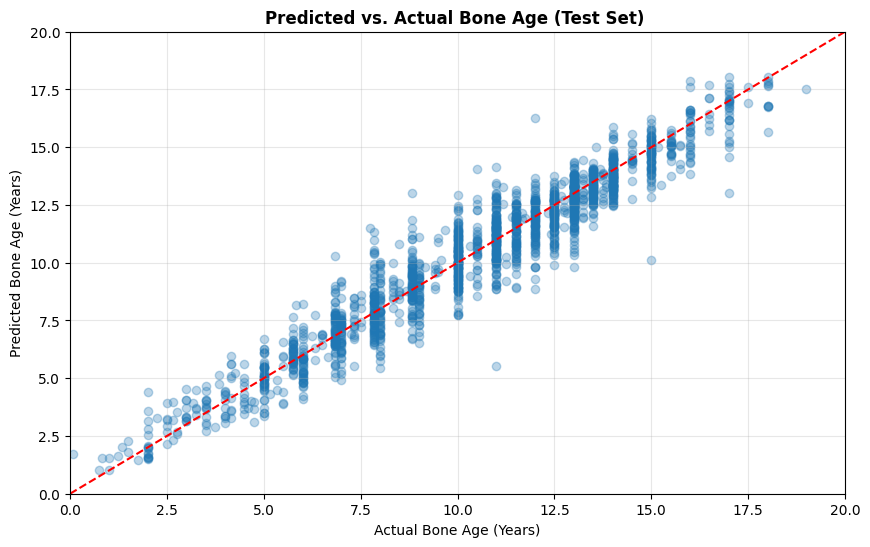

In [11]:
# ==============================================================================
# 6. FINAL EVALUATION AND DELIVERABLES
# ==============================================================================

print("\nFINAL EVALUATION on Test Set...")

# Load best model weights
try:
    cnn_model.load_state_dict(torch.load(MODEL_PATH))
    print("✓ Best model checkpoint loaded successfully.")
except Exception as e:
    print(f"❌ ERROR loading model weights: {e}")
    # Proceed, but results will be based on the last epoch's weights

# 1. Run inference on the Test Set
_, test_mae, test_preds, test_targets = evaluate_model(cnn_model, test_loader, criterion, device)

# --- Calculate Full Regression Metrics ---
test_mse = mean_squared_error(test_targets, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_targets, test_preds)

print("\n" + "="*60)
print("FINAL TEST SET REGRESSION RESULTS")
print("="*60)
print(f"Mean Absolute Error (MAE): {test_mae:.4f} years [cite: 108]")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f} years [cite: 111]")
print(f"Coefficient of Determination (R²): {test_r2:.4f} [cite: 114]")

# --- 2. Scatter Plot of Predicted vs. Actual Age ---
plt.figure(figsize=(10, 6))
plt.scatter(test_targets, test_preds, alpha=0.3)
plt.plot([0, 20], [0, 20], 'r--') # Ideal y=x line
plt.title('Predicted vs. Actual Bone Age (Test Set) ', fontweight='bold')
plt.xlabel('Actual Bone Age (Years)')
plt.ylabel('Predicted Bone Age (Years)')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid(True, alpha=0.3)
plt.show()

---

## 7. Fairness & Bias Analysis

### Gender-Wise Performance Comparison
Analyzing model performance separately for male and female patients to identify potential bias.

**Analysis includes:**
- MAE, RMSE, and R² for each gender
- Sample count distribution
- Performance difference metrics

In [12]:
# ==============================================================================
# 7. GENDER-WISE BIAS ANALYSIS
# ==============================================================================

print("\n" + "="*60)
print("GENDER-WISE PERFORMANCE & BIAS ANALYSIS ")
print("="*60)

# Create a DataFrame for evaluation
test_df_eval = test_df.copy().reset_index(drop=True)
test_df_eval['predicted_age'] = test_preds
test_df_eval['actual_age'] = test_targets

# --- Metric Calculation Function ---
def calculate_gender_metrics(df):
    y_true = df['actual_age'].values
    y_pred = df['predicted_age'].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2, len(df)

# Separate by gender (Male=True, Female=False)
male_df = test_df_eval[test_df_eval['male'] == True] 
female_df = test_df_eval[test_df_eval['male'] == False]

male_mae, male_rmse, male_r2, male_count = calculate_gender_metrics(male_df)
female_mae, female_rmse, female_r2, female_count = calculate_gender_metrics(female_df)

# Create comparison table
bias_analysis = pd.DataFrame({
    'Metric': ['MAE (Years)', 'RMSE (Years)', 'R² Score', 'Count'],
    'Male (M)': [male_mae, male_rmse, male_r2, male_count],
    'Female (F)': [female_mae, female_rmse, female_r2, female_count],
    'Difference (M - F)': [
        male_mae - female_mae,
        male_rmse - female_rmse,
        male_r2 - female_r2,
        male_count - female_count
    ]
})

print(f"Total Test Samples: {len(test_df_eval)}\n")
print(bias_analysis.to_string(index=False, float_format='%.4f'))

print("\n✓ All core deliverables implemented and analyzed. Project complete! 🥳")


GENDER-WISE PERFORMANCE & BIAS ANALYSIS 
Total Test Samples: 1892

      Metric  Male (M)  Female (F)  Difference (M - F)
 MAE (Years)    0.6974      0.7212             -0.0238
RMSE (Years)    0.9149      0.9597             -0.0448
    R² Score    0.9318      0.9052              0.0267
       Count 1025.0000    867.0000            158.0000

✓ All core deliverables implemented and analyzed. Project complete! 🥳
